In [11]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft, ifftshift, fftshift
# explicit dependence on time vs others depend only on X (GBM etc)
# the closer we are to maturity the stronger the mean reversion to the mean growth rate for Brownian Bridge - 
# wide divergence at start but less as get close to T. It has a fixed end point and fixed starting point, vs fixed start for other models.

[Text(0.5, 0, 't'),
 Text(0, 0.5, 'X'),
 Text(0.5, 1.0, 'Brownian Bridge $dX = ((b-X)/(T-t))dt + \\sigma*dW$')]

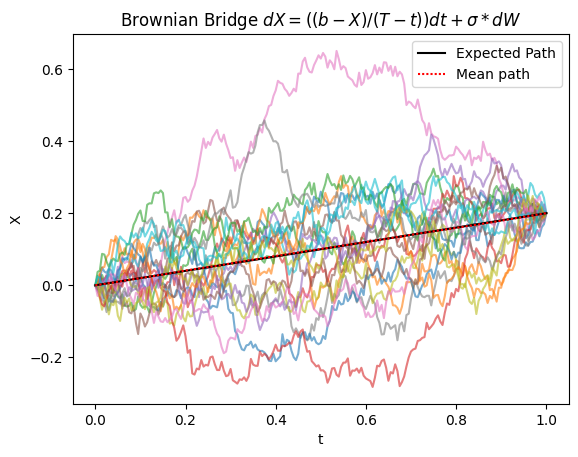

In [13]:
# dX = (b-X)/(T-t)*dt + sigma*dW

# Parameters and time grid
npaths = 20000
nsteps = 200
T = 1
dt = T / nsteps
t = np.linspace(0, T, nsteps + 1)

# Model parameters
sigma = 0.3
a = 0
b = 0.2
# c = 1 # proportionality constant of the mean-reversion strength c/(T-t)

# Monte Carlo method 1
# Allocate and initialise paths
X = np.zeros((nsteps + 1, npaths))
X[0, :] = a
X[-1, :] = b

# Compute the Brownian bridge with Euler-Maruyama
# for i in range(nsteps):
#     X[i + 1, :] = X[i, :] + (b - X[i, :]) / (nsteps - i + 1) + sigma * np.random.randn(npaths) * np.sqrt(dt)

# Monte Carlo Simulation for Brownian Bridge - Chey
# W = np.cumsum(np.sqrt(dt) * np.random.randn(nsteps, npaths), axis=0)
# time_factor = np.linspace(0, T, nsteps).reshape(-1, 1)
# B = W - time_factor * W[-1, :] / T
# B = np.concatenate([np.zeros((1, npaths)), B], axis=0)


## Monte Carlo method 2
# Compute the increments of driftless arithmetic Brownian motion
dW = sigma*np.random.randn(nsteps,npaths)*np.sqrt(dt)

# Accumulate the increments of arithmetic Brownian motion
W = np.cumsum(np.vstack([a * np.ones((1, npaths)), dW]), axis=0)

## Compute the Brownian bridge with X(t) = W(t) + (b-W(T))/T*t
X = W + np.tile(b-W[-1,:],(nsteps+1,1))/T*np.tile(t,(npaths,1)).T

# Expected, mean and sample paths
fig, ax = plt.subplots()
EX = a + (b - a) / T * t
ax.plot(t,X[:, ::1000], alpha=0.6)
ax.plot(t, EX, 'k', label='Expected Path')
ax.plot(t, np.mean(X, axis=1), 'r',linestyle= (0, (1,1)), label='Mean path')
ax.legend(loc=0)
ax.set(xlabel='t', ylabel='X', title=r'Brownian Bridge $dX = ((b-X)/(T-t))dt + \sigma*dW$')
# plt.savefig('bbpaths.png')

Text(0.5, 1.0, 'Comparing the theoretical mean of Brownian Bridge with the one estimated via MC')

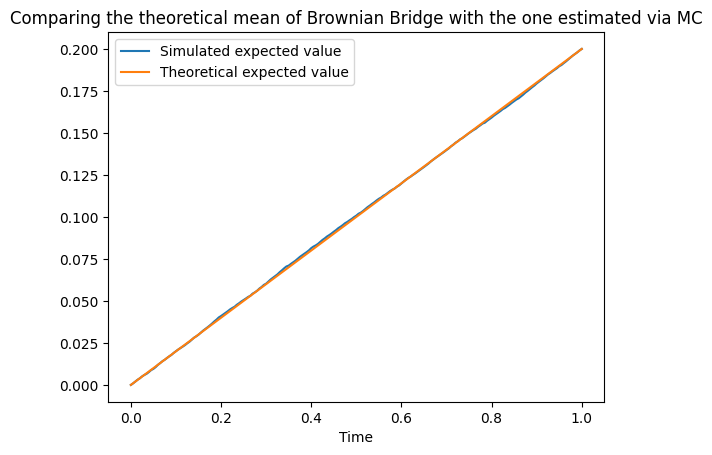

In [14]:
# Estimate mean of X(t) from the simulations and compare to the true one
plt.figure()
plt.plot(t, np.mean(X, axis=1), label='Simulated expected value')
plt.plot(t, EX, label='Theoretical expected value')
plt.xlabel('Time')
plt.legend(loc=0)
plt.title('Comparing the theoretical mean of Brownian Bridge with the one estimated via MC') 

<>:8: SyntaxWarning: invalid escape sequence '\ '
<>:8: SyntaxWarning: invalid escape sequence '\ '
/var/folders/sg/z_br3z317db2fzjxdgwhxkg40000gn/T/ipykernel_1127/2603341459.py:8: SyntaxWarning: invalid escape sequence '\ '
  plt.ylabel('$\ Var(X) = E[(X^2)-(E(X)^2)]$')


Text(0.5, 1.0, 'Brownian Bridge: Mean Square Deviation')

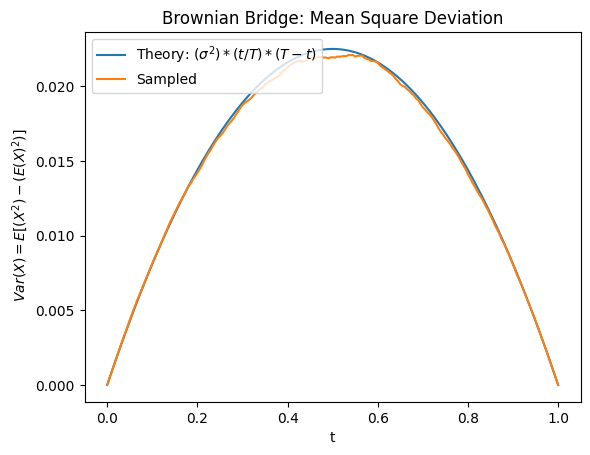

In [15]:
# Variance = mean square deviation = mean square displacement of random part
plt.figure()
s=0
plt.plot(t, (sigma**2)*(t/T)*(T-t), label=r'Theory: $(\sigma^2)*(t/T)*(T-t)$')
plt.plot(t, np.var(X, axis=1), label='Sampled')
plt.legend(loc='upper left')
plt.xlabel('t')
plt.ylabel('$\ Var(X) = E[(X^2)-(E(X)^2)]$')
plt.title('Brownian Bridge: Mean Square Deviation')

<>:11: SyntaxWarning: invalid escape sequence '\p'
<>:11: SyntaxWarning: invalid escape sequence '\p'
/var/folders/sg/z_br3z317db2fzjxdgwhxkg40000gn/T/ipykernel_1127/3118006984.py:11: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel('E(|X-E(X)|) = $(2Var(X)/\pi)^{1/2}$')


Text(0.5, 1.0, 'Brownian Bridge: Mean Absolute Deviation')

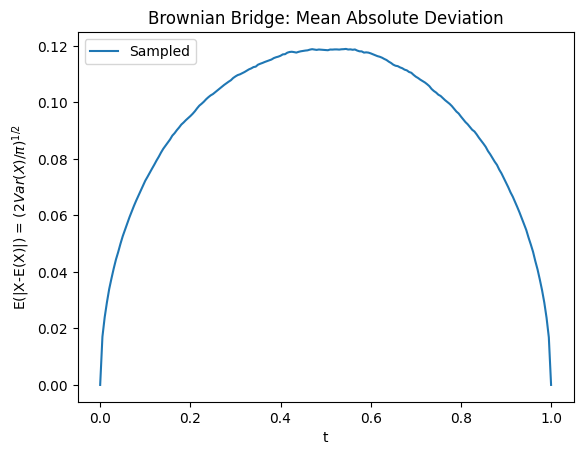

In [16]:
# Mean absolute deviation
arr = []
for i in range(np.shape(X)[1]):
    a = np.abs(X[:,i] - EX)
    arr.append(a)
    
plt.figure()
plt.plot(t, np.mean(arr, axis=0), label='Sampled')
plt.legend(loc='upper left')
plt.xlabel('t')
plt.ylabel('E(|X-E(X)|) = $(2Var(X)/\pi)^{1/2}$')
plt.title('Brownian Bridge: Mean Absolute Deviation')

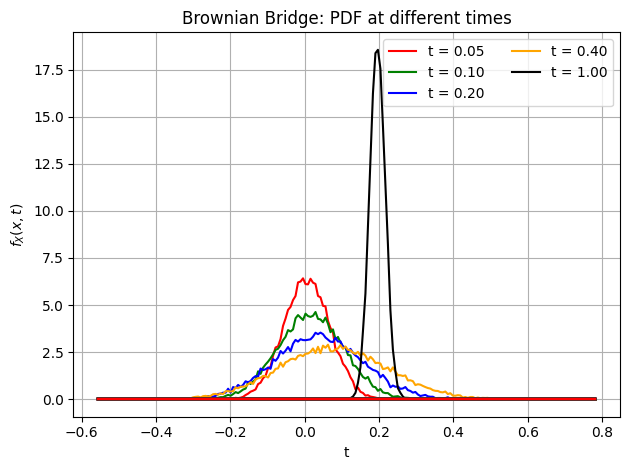

In [17]:
# Probability density function at different times
lins = np.linspace(np.min(X),np.max(X), 200)

# Initialise arrays for sampled PDFs
fs = np.zeros((len(lins), len(t)))  # sampled

# Compute PDFs
for i, t in enumerate([0.05, 0.1, 0.2, 0.4, 1.0]):
    bincounts, _ = np.histogram(X[int(t * nsteps-1), :], bins=lins, density=True)
    fs[:-1, i] = bincounts

plt.figure()
plt.gca().set_prop_cycle(color=['red', 'green', 'blue', 'orange', 'black'])
plt.plot(lins, fs, label = 'Sampled')
plt.legend(['t = 0.05', 't = 0.10', 't = 0.20', 't = 0.40', 't = 1.00'] , ncol=2, loc=0)
plt.ylabel('$f_X(x,t)$')
plt.title('Brownian Bridge: PDF at different times')
plt.xlabel('t')
plt.grid()
plt.tight_layout()

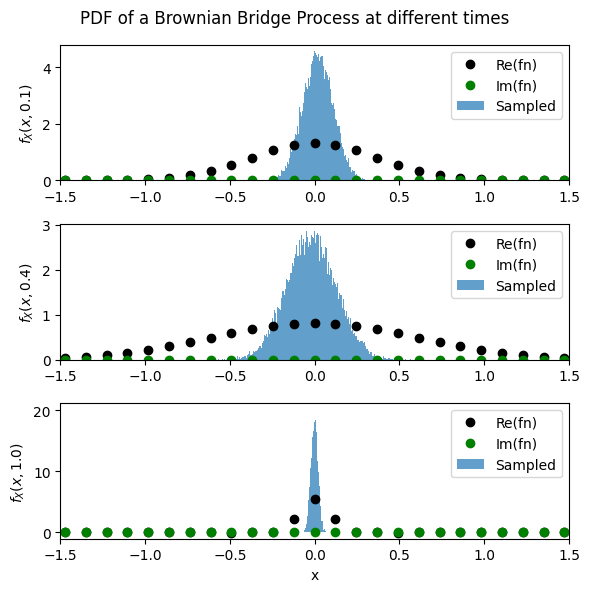

In [25]:
# FT Approx of Pdf using IFFT
t = np.linspace(0, T, nsteps + 1)
N = 512
dx = 0.1
upperx = N * dx
x = dx * np.arange(-N/2, N/2)
dxi = 2 * np.pi / (N * dx)
xi = dxi * np.arange(-N/2, N/2)

fig, ax = plt.subplots(3,1, figsize=(6,6))
for i,time in enumerate([20, 80, -2]):

    # Pulsation space: xi
    variance = (t[time]*(T-t[time])) / T
    char_func = np.exp(-0.5 * variance * xi**2)
    f_X = fftshift(fft(ifftshift(char_func))) / upperx
    if i==2:
        ax[i].hist(X[time,:]-b,density=True,bins=nsteps, alpha=0.7)
        ax[i].plot(xi,np.real(f_X), 'ko', linewidth=2)
        ax[i].plot(xi,np.imag(f_X), 'go')
    elif i == 1:
        ax[i].hist(X[time,:]-b*0.5,density=True,bins=nsteps, alpha=0.7)
        ax[i].plot(xi,np.real(f_X), 'ko', linewidth=2)
        ax[i].plot(xi,np.imag(f_X), 'go')
    else:
        ax[i].hist(X[time,:],density=True,bins=nsteps, alpha=0.7)
        ax[i].plot(xi,np.real(f_X), 'ko', linewidth=2)
        ax[i].plot(xi,np.imag(f_X), 'go')
    
    ax[i].set_ylabel(f'$f_X(x, {t[time]:.1f})$')
    ax[i].set_xlim(-1.5,1.5)
    ax[i].legend(['Re(fn)', 'Im(fn)','Sampled'])

plt.suptitle('PDF of a Brownian Bridge Process at different times')
plt.xlabel('x')
plt.tight_layout()

Text(0.5, 1.0, 'Brownian Bridge: autocovariance')

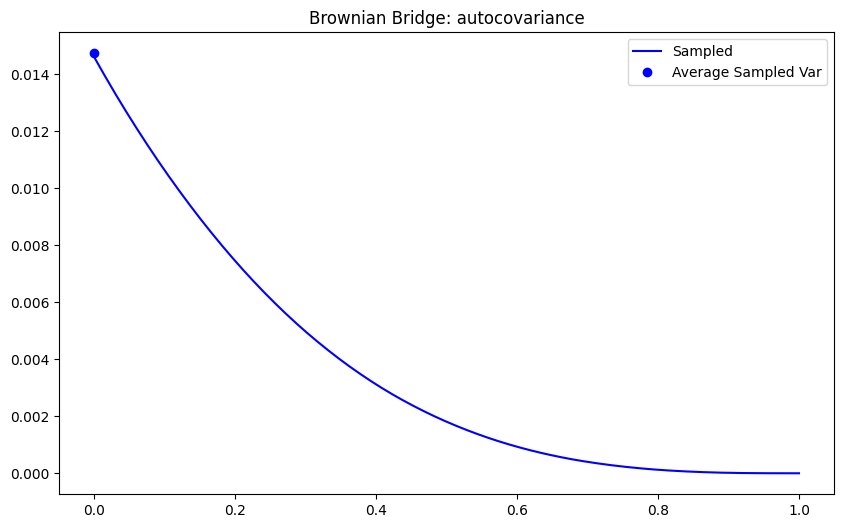

In [19]:
# Autocovariance
from scipy.signal import correlate

# Initialize the autocovariance array
C = np.zeros((npaths, 2 * nsteps+1))

# Calculate the autocovariance for each path
for i in range(npaths):
    deviation = X[:, i] - EX
    # Compute autocorrelation and normalize by the number of steps
    C[i, :] = correlate(deviation, deviation, mode='full') / nsteps

# Average over all paths
C = np.mean(C, axis=0)

plt.figure(figsize=(10, 6))
t = np.linspace(0, T, nsteps)

# Plot theoretical autocovariance - (t∧z−s)(T−t∨z))/(T-s)
# plt.plot(t, ____, 'r', label='Theory')

# Plot sampled autocovariance
# plt.plot(0, sigma**2 / (2 * alpha), 'ro', label ='Theory Variance for Infinite t')  # Var for infinite t (sigma^2 / (2 * alpha))
plt.plot(t, C[-nsteps:], 'b', label='Sampled')
plt.plot(0, np.mean(np.var(X, axis=1)), 'bo', label='Average Sampled Var') # average sampled variance
plt.legend(loc=0)
plt.title('Brownian Bridge: autocovariance')